## Let's implement CCS from scratch.
This will deliberately be a simple (but less efficient) implementation to make everything as clear as possible.

In [5]:
from tqdm import tqdm
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression

# Let's just try IMDB for simplicity
data = load_dataset("amazon_polarity")["test"]

# Here are a few different model options you can play around with:
model_name = "deberta"
# model_name = "gpt-j"
# model_name = "t5"

# if you want to cache the model weights somewhere, you can specify that here
cache_dir = None

if model_name == "deberta":
    model_type = "encoder"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
    model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
    model.cuda()
elif model_name == "gpt-j":
    model_type = "decoder"
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
    model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
    model.cuda()
elif model_name == "t5":
    model_type = "encoder_decoder"
    tokenizer = AutoTokenizer.from_pretrained("t5-11b", cache_dir=cache_dir)
    model = AutoModelForSeq2SeqLM.from_pretrained("t5-11b", cache_dir=cache_dir)
    model.parallelize()  # T5 is big enough that we may need to run it on multiple GPUs
else:
    print("Not implemented!")

/opt/conda/envs/ccs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v2-xxlarge and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [103]:
# manually executes model choice!
model_type = "encoder"
# MODEL_NAME = "microsoft/deberta-v3-base"
MODEL_NAME = "microsoft/deberta-v2-xxlarge"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v2-xxlarge and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForMaskedLM(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1536, padding_idx=0)
      (LayerNorm): LayerNorm((1536,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-47): 48 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1536, out_features=1536, bias=True)
              (key_proj): Linear(in_features=1536, out_features=1536, bias=True)
              (value_proj): Linear(in_features=1536, out_features=1536, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1536, out_features=1536, bias=True)
              (LayerNorm): LayerNorm((1536,), eps=1e-07, elementwise_affine=Tr

## First let's write code for extracting hidden states given a model and text. 
How we do this exactly will depend on the type of model.

In [59]:
def get_encoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, truncation=True, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["hidden_states"]
    
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_encoder_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder-decoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    decoder_text_ids = tokenizer("", return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, decoder_input_ids=decoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["encoder_hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given a decoder model and some text, gets the hidden states (in a given layer, by default the last) on that input text

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize (adding the EOS token this time)
    input_ids = tokenizer(input_text + tokenizer.eos_token, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(input_ids, output_hidden_states=True)

    # get the last layer, last token hidden states
    hs_tuple = output["hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_hidden_states(model, tokenizer, input_text, layer=-1, model_type="encoder"):
    fn = {"encoder": get_encoder_hidden_states, "encoder_decoder": get_encoder_decoder_hidden_states,
          "decoder": get_decoder_hidden_states}[model_type]

    return fn(model, tokenizer, input_text, layer=layer)

In [60]:
# specifies embedding fn
# default model_type = "encoder" is fine, since we use deberta
EMBEDDING_FN = lambda input_text: get_hidden_states(model, tokenizer, input_text)

## Now let's write code for formatting data and for getting all the hidden states.

In [61]:
# prompt scaffolding for IMDB dataset
# included in base CCS implementation
def format_imdb(text, label):
    """
    Given an imdb example ("text") and corresponding label (0 for negative, or 1 for positive), 
    returns a zero-shot prompt for that example (which includes that label as the answer).
    
    (This is just one example of a simple, manually created prompt.)
    """
    return "The following movie review expresses a " + ["negative", "positive"][label] + " sentiment:\n" + text

In [62]:
# featurizer for supervised CCS
def featurizer_benchmark(text):
    return EMBEDDING_FN(format_imdb(text, 1)) - EMBEDDING_FN(format_imdb(text, 0))

In [63]:
# featurizer omitting CCPs!
def featurizer_CCPless(text):
    # return EMBEDDING_FN(text)
    return EMBEDDING_FN("The following movie review expresses a positive sentiment:\n" + text)

In [113]:
# specifies featurizer fn
FEATURIZER_FN = featurizer_CCPless
# FEATURIZER_FN = featurizer_benchmark

In [106]:
# subsamples dataset
N = 100
subsample = data[np.random.choice(len(data), N, replace=False)]

In [114]:
# featurizes subsample
X = np.array([FEATURIZER_FN(text) for text in tqdm(subsample["content"])])
y = np.array(subsample["label"])

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


In [115]:
# gets difference of means
exgy = X[y == 1].mean(axis = 0)
exgn = X[y == 0].mean(axis = 0)
diff = exgy - exgn

# Metrics
- salience (proportion of X explained by diff)
<!-- - power (proportion of y explained by diff) -->
- accuracy (proportion of correct predictions)

In [116]:
# gets covariance matrix of X
cmx = np.cov(X.T)

# gives salienece as rayleigh quotient w normalized trace
# = e.val / sum e.vals
print("salience: ", np.round(diff.T @ cmx @ diff / diff.dot(diff) / np.trace(cmx), 2))

salience:  0.02


In [117]:
# overall mean x
ex = X.mean(axis = 0)

# gets vector of diff scores
X_diffs = (X - ex) @ diff

# gets sign of diff scores
X_signs = np.sign(X_diffs)

(array([[ 0.,  0.,  0.,  0.,  0.,  1.,  4.,  2.,  3.,  6., 12.,  6.,  4.,
          3.,  0.,  3.,  1.,  1.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  1.],
        [ 1.,  1.,  4.,  6., 12.,  7.,  4.,  8.,  4.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]]),
 array([-5.25164461, -4.65525341, -4.05886221, -3.46247077, -2.86607957,
        -2.26968837, -1.67329717, -1.07690585, -0.48051462,  0.11587663,
         0.71226788,  1.30865908,  1.9050504 ,  2.50144172,  3.09783292,
         3.69422412,  4.29061556,  4.88700676,  5.48339796,  6.07978916,
         6.67618036,  7.27257156,  7.86896276,  8.46535397,  9.06174564,
         9.65813637, 10.25452805, 10.85091877, 11.44731045, 12.04370117,
        12.64009285]),
 <a list of 2 BarContainer objects>)

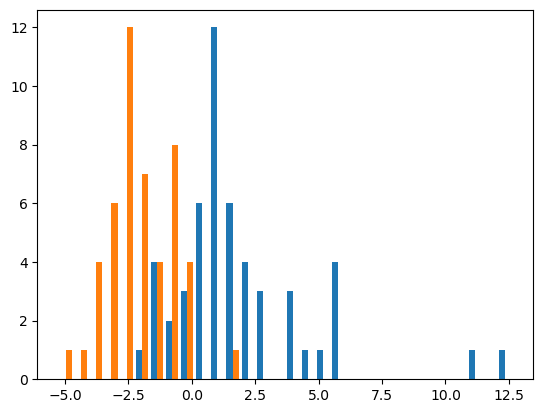

In [118]:
# plots diff scores for positive and negative examples
import matplotlib.pyplot as plt
diff_y = X_diffs[y == 1]
diff_n = X_diffs[y == 0]

plt.hist([diff_y, diff_n], bins=30, label=['positive', 'negative'])

In [119]:
# converts y to (1, -1) vector
y_signs = np.where(y == 0, -1, 1)

# gets Pr[correct]
pr_correct = (X_signs.dot(y_signs) / len(y_signs) + 1) / 2
print("classifier accuracy: ", np.round(pr_correct, 2))

classifier accuracy:  0.9


In [120]:
# alternatively, just gets sklearn to do it
lr = LogisticRegression(class_weight='balanced')
lr.fit(X, y)
print("Logistic regression accuracy: {}".format(lr.score(X, y)))

Logistic regression accuracy: 1.0


/opt/conda/envs/ccs/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         47.,  5.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  1.,  1.,  3.,  1.,  2.,  3.,  1.,  7.,  4.,
          2.,  4.,  2.,  1.,  2.,  1.,  6.,  1.,  3.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.]]),
 array([-5.25164461, -5.02042371, -4.78920282, -4.55798192, -4.32676102,
        -4.09554013, -3.86431923, -3.63309833, -3.40187744, -3.17065654,
        -2.93943564, -2.70821474, -2.47699385, -2.24577295, -2.01455205,
        -1.78333116, -1.55211026, -1.32088936, -1.08966846, -0.85844757,
        -0.62722667, -0.39600577, -0.16478488,  0.06643602,  0.29765692,
         0.52887781,  0.76009871,  0.99131961,  1.22254051,  1.4537614 ,
         1.6849823 ]),
 <a list of 2 BarContainer objects>)

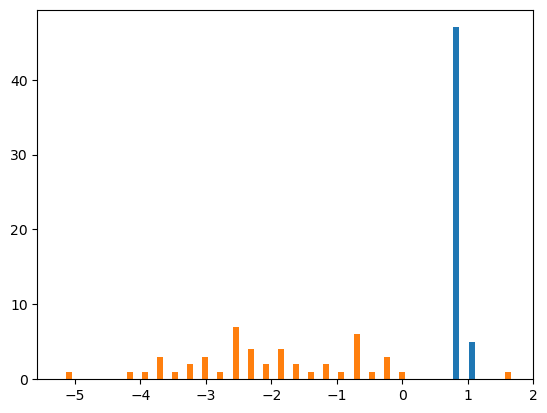

In [121]:
# plots LR predictions by class
preds = lr.predict_proba(X)[:, 1]
preds_y = preds[y == 1]
preds_n = X_diffs[y == 0]

plt.hist([preds_y, preds_n], bins=30, label=['positive', 'negative'])

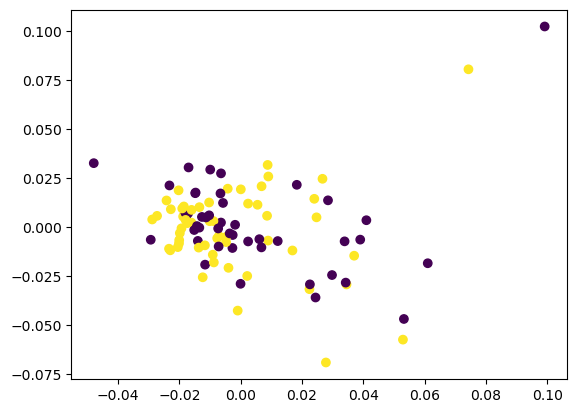

In [74]:
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(X)
plot = plt.scatter(Xt[:,4], Xt[:,5], c=y)
plt.show()

(array([[ 2.,  1.,  2.,  1.,  1.,  1.,  7., 16.,  8.,  4.,  1.,  1.,  2.,
          0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.],
        [ 0.,  0.,  1.,  2.,  2.,  7., 24., 13.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]]),
 array([-4.05496216, -3.52852416, -3.0020864 , -2.4756484 , -1.94921052,
        -1.42277253, -0.89633465, -0.36989674,  0.15654118,  0.68297911,
         1.20941699,  1.73585498,  2.26229286,  2.78873086,  3.31516862,
         3.84160662,  4.36804438,  4.89448261,  5.42092037,  5.94735813,
         6.47379637,  7.00023413,  7.52667189,  8.05311012,  8.57954788,
         9.10598564,  9.6324234 , 10.15886116, 10.68529987, 11.21173763,
        11.73817539]),
 <a list of 2 BarContainer objects>)

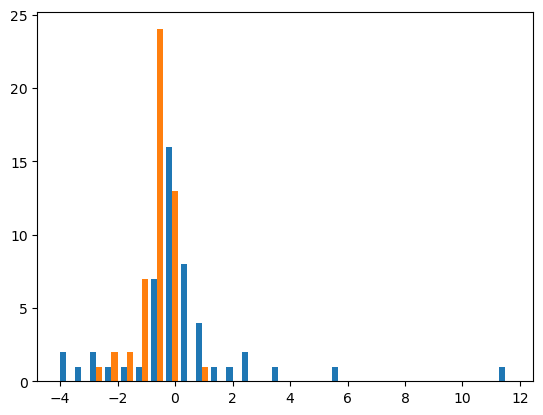

In [30]:
# arbirary plotter!
preds = Xt[: , 0]
preds_y = preds[y == 1]
preds_n = X_diffs[y == 0]

plt.hist([preds_y, preds_n], bins=30, label=['positive', 'negative'])

In [31]:
# samples from extremal values
SCORE_THRESHOLD = 2
truthy_indices = np.where(X_diffs > SCORE_THRESHOLD)[0]

In [37]:
# samples truthy sentence
i = random.choice(truthy_indices)
subsample["content"][i]

'I ordered this for my daughter for her stocking. I know she will love it! She is really into the lift-the-flap books.'